In [1]:
# TODO which one?
#git clone https://github.com/lucidrains/iTransformer.git
#import iTransformer
import sys
sys.path.append('/vol/fob-vol7/nebenf21/reinbene/bene/MA/iTransformer') 
from iTransformer import iTransformer

import torch

from utils import data_handling, helpers, training_functions
import config
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset


WINDOW_SIZE = 96
PRED_LENGTH = (96)
TRAIN_EPOCH = 15
TUNE_EPOCH = 5

four_weeks = 24*7*4
TRAIN_EPOCHS = 4
TUNE_EPOCHS = 2

output_path = config.CONFIG_OUTPUT_PATH["final_outputs"]

print("Import succesfull")

Import succesfull


In [3]:
class SlidingWindowNoOverlap(Dataset):
    """
    Extra implementation of the dataloader which does not overlap data
    Used for inference to get overall MwH error 
    """
    def __init__(self, data, WINDOW_SIZE, PRED_LENGTH):
        self.data = data
        self.window_size = WINDOW_SIZE
        self.pred_lengths = PRED_LENGTH

        if type(PRED_LENGTH) == int:
            self.max_pred_lengths = PRED_LENGTH
        else:
            self.max_pred_lengths = max(PRED_LENGTH)

        # Adjust the length to ensure non-overlapping windows
        self.num_windows = (self.data.size(0) - self.window_size) // (self.window_size + self.max_pred_lengths)

    def __len__(self):
        return self.num_windows

    def __getitem__(self, idx):
        # Calculate the start index for the current window
        start_idx = idx * (self.window_size + self.max_pred_lengths)
        end_idx = start_idx + self.window_size

        # Check if the index is within bounds
        if start_idx < 0 or (end_idx + self.max_pred_lengths) > self.data.size(0):
            raise IndexError("Index out of bounds")

        # Get the window of data
        window = self.data[start_idx:end_idx]

        # Get the targets
        if type(self.pred_lengths) == int:
            targets = self.data[end_idx:end_idx + self.pred_lengths]
        else:
            targets = tuple(
                self.data[end_idx:end_idx + PRED_LENGTH]
                for pred_length in self.pred_lengths
            )

        return window, targets

# Select dataset for transfer learning

In [4]:
# building genome project dataset
data_tensor = data_handling.load_genome_project_data()
data_dict, standadizer = data_handling.train_test_split_eu_elec(data_tensor, standardize=True)
# convert to datalaoder
gp_dict_tensor = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12}
gp_dict_train =  {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12}
gp_dict_target =  {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12}

benchmark_list_name = config.CONFIG_OUTPUT_PATH["itransformer"] / "benchmark_list_case_study.pkl"
baseline_list_name =  config.CONFIG_OUTPUT_PATH["itransformer"] / "baseline_list_case_study.pkl"
benchmark_one_model_name =  config.CONFIG_OUTPUT_PATH["itransformer"] / "benchmark_one_model_case_study.pkl"


# Initialize empty lists
month_mse = []
month_mse_baseline = []
one_model_tl = []
load = []

# Load predictions if available
try:
  with open(benchmark_list_name, 'rb') as file:
    month_mse = pickle.load(file)
except Exception as e:
  print(f"Could not load {benchmark_list_name}: {e}")
  month_mse = []

try:
  with open(baseline_list_name, "rb") as file:
    month_mse_baseline = pickle.load(file)
except Exception as e:
  print(f"Could not load {baseline_list_name}: {e}")
  month_mse_baseline = []

try:
  with open(benchmark_one_model_name, "rb") as file:
    one_model_tl = pickle.load(file)
except Exception as e:
  print(f"Could not load {benchmark_one_model_name}: {e}")
  one_model_tl = []


# add fine-tuning datalaoders
# create a smaller subset of the train dataset
standadize_dict = None
standadizer_list = []
for key, value in gp_dict_train.items():
  horizon = value*four_weeks

  test_split = data_tensor[horizon-four_weeks:horizon:,:]
  train_split = data_tensor[:horizon,:]
  gp_dict_tensor[key] =  test_split
  long_train = data_handling.SlidingWindowTimeSeriesDataset(train_split , WINDOW_SIZE, PRED_LENGTH)
  long_target = SlidingWindowNoOverlap(test_split, WINDOW_SIZE, PRED_LENGTH)
  gp_dict_train[key] = data_handling.DataLoader(long_train , batch_size=32, shuffle=True)
  gp_dict_target[key] = data_handling.DataLoader(long_target , batch_size=32, shuffle=False)

# define parameters for all models
best_parameters = {'depth': 2, 'dim': 256, 'dim_head': 56, 'heads': 4, 'attn_dropout': 0.2, 'ff_mult': 4, 'ff_dropout': 0.2, 
                        'num_mem_tokens': 4, 'learning_rate': 0.0005}

# forecast first month
Task: day ahead forecast

Our baseline is: last day lag by 24h

benchmark: pre-trained itransformer zero-shot

In [ ]:
# define needed functions
def lag_loss(horizon, days):
    # calc first month simple prediciton
    hours = 3*days

    preds = horizon[:-hours,:] 
    target = horizon[hours:,:]    
    assert preds.shape == target.shape
    mse_loss = torch.nn.L1Loss(reduction="sum")

    mse = mse_loss(preds, target)
    return mse.item()

# benchmark
def fine_tune(model, dataloader_train, dataloader_validation, device, epoch=5):

    # defining all needed instances
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    writer = SummaryWriter(log_dir=config.CONFIG_LOGS_PATH["itransformer"])

    # run model training as mentioned in the original paper
    _, model = training_functions.train_one_epoch(epoch, model, device, dataloader_train, dataloader_validation, optimizer, \
                                                        writer, save_model=False, validate=False)
    return model, device


def predict_after_startup(model, loss_list, device, gp_dict=gp_dict_train):
    for key in gp_dict.keys():
        print(key)
        if key == 12: break
        if key == 1: continue

        model, device = fine_tune(model, gp_dict[key], None, device, epoch=TUNE_EPOCHS)
        metrics_fine_tuned = helpers.full_eval(model, gp_dict[key+1], device, reduction="sum")[1]
        loss_list.append(metrics_fine_tuned)   
    return loss_list



# setup base model and pre-traiend model
model_path = config.CONFIG_MODEL_LOCATION["itransformer"] / "ELD" / "ELD_full_dataset_best_val_loss.pt"

dataloader = gp_dict_target[1]
inputs, _ = next(iter(dataloader))
num_variates = inputs.size(2)

model_config = {
            'num_variates': num_variates,
            'lookback_len': WINDOW_SIZE,
            'depth': best_parameters["depth"],
            'dim': best_parameters["dim"],
            'num_tokens_per_variate': 1,
            'pred_length': PRED_LENGTH,
            'dim_head': best_parameters["dim_head"],
            'heads': best_parameters["heads"],
            'attn_dropout': best_parameters["attn_dropout"],
            'ff_mult': best_parameters["ff_mult"],
            'ff_dropout': best_parameters["ff_dropout"],
            'num_mem_tokens': best_parameters["num_mem_tokens"],
            'use_reversible_instance_norm': True,
            'reversible_instance_norm_affine': True,
            'flash_attn': True
        }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


checkpoint = torch.load(model_path,map_location='cpu')

# values are all set to zero (beta) and one (gamma), array needs to be adapted to num_variates
# learned affine parameters are series specific and need to be relearned for new series
# value are kept at 1 and 0 for stationary normalization
beta = checkpoint["model_state_dict"]["reversible_instance_norm.beta"] 
gamma = checkpoint["model_state_dict"]["reversible_instance_norm.gamma"]

    # make affine parameter list longer if target series has more channels
if beta.shape[0] < num_variates:
    factor = (num_variates // beta.shape[0]) + 1
    beta  = torch.cat([beta] *factor)
    gamma = torch.cat([gamma] * factor)

# shorten affine parameters to exact number
checkpoint["model_state_dict"]["reversible_instance_norm.beta"] = beta[:num_variates]
checkpoint["model_state_dict"]["reversible_instance_norm.gamma"] = gamma[:num_variates]


# load models
benchmark_model = iTransformer(**model_config).to(device)
benchmark_model.load_state_dict(checkpoint['model_state_dict'])


Using device: cuda:0


<All keys matched successfully>

In [ ]:
if len(month_mse_baseline) == 0:
    # baseline month 1
    loss = lag_loss(gp_dict_tensor[1], 3)
    month_mse_baseline.append(loss)

if len(month_mse) == 0:
    # benchmark month 1
    zero_shot_loss = helpers.full_eval(benchmark_model, dataloader, device, reduction="sum")[1]
    month_mse.append(zero_shot_loss)
    one_model_tl.append(zero_shot_loss)

if len(load) == 0:
    load.append(gp_dict_tensor[1][3:].sum().item())


In [ ]:
benchmark_model.load_state_dict(checkpoint['model_state_dict'])

for key in gp_dict_train.keys():
    if key < len(one_model_tl): break
    if key == 12: break
    benchmark_model, device = fine_tune(benchmark_model, gp_dict_train[key], None, device, epoch=3)
    metrics_benchmark = helpers.full_eval(benchmark_model, gp_dict_target[key + 1], device, reduction="sum")[1]
    one_model_tl.append(metrics_benchmark)

# save as pickle
with open(benchmark_one_model_name, 'wb') as file:
    pickle.dump(one_model_tl, file)

Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 124.25it/s]


In [ ]:
for key in gp_dict_train.keys():
    if key == 12: break
    print(key)
    if key <= len(month_mse):
        benchmark_model.load_state_dict(checkpoint['model_state_dict'])
        benchmark_model, device = fine_tune(benchmark_model, gp_dict_train[key], None, device, epoch=TRAIN_EPOCHS)
        metrics_benchmark = helpers.full_eval(benchmark_model, gp_dict_target[key + 1], device, reduction="sum")[1]
        month_mse.append(metrics_benchmark)

        # save as pickle
        with open(benchmark_list_name, 'wb') as file:
                pickle.dump(month_mse, file)

    if key <= len(month_mse_baseline):
        baseline_model = iTransformer(**model_config).to(device)
        baseline_model, device = fine_tune(baseline_model, gp_dict_train[key], None, device, epoch=TRAIN_EPOCHS)
        metrics_baseline = helpers.full_eval(baseline_model, gp_dict_target[key + 1], device, reduction="sum")[1]
        month_mse_baseline.append(metrics_baseline)

        # save as pickle
        with open(baseline_list_name, 'wb') as file:
                pickle.dump(month_mse_baseline, file)

1


Epoch: 1:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


2


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 175.12it/s]


3


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


4


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 158.81it/s]


5


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 72.97it/s]


6


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


7


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


8


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


9


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


10


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 154.66it/s]


11


Epoch: Validating: 100%|██████████| 1/1 [00:00<00:00, 40.82it/s]


# forecast following months

Baseline: train itransformer on last month, following month: finetune

Benchmark: fine-tune from previous month

In [ ]:
load = []

for key in gp_dict_train.keys():
    load.append(gp_dict_tensor[key][3:].sum().item())


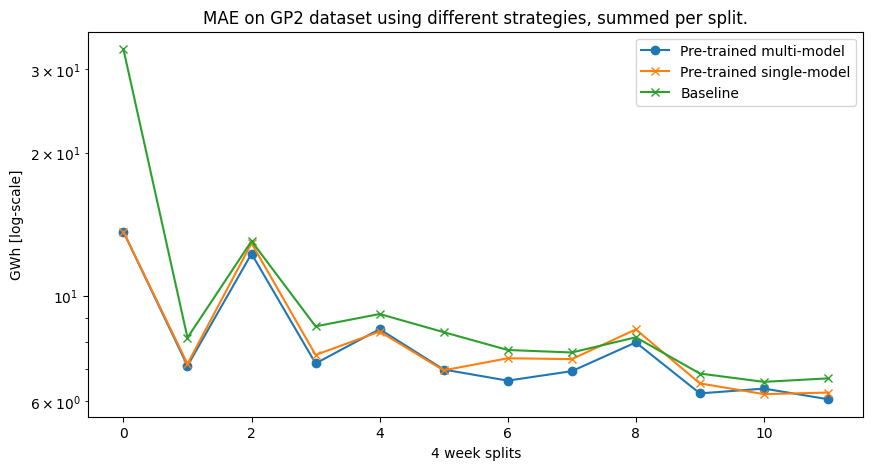

In [21]:
# Plotting the data
gw_conversion = 1000000  

month_benchmark_gwh = [value / gw_conversion for value in month_mse]
month_baseline_gwh = [value / gw_conversion for value in month_mse_baseline]
month_one_model_gwh = [value / gw_conversion for value in one_model_tl]


plt.figure(figsize=(10, 5))
plt.plot(month_benchmark_gwh, label='Pre-trained multi-model', marker='o')
#plt.plot(load, label='Overall load', marker='x')
#plt.plot(last_three_days, label='Baseline past days', marker='x')
plt.plot(month_one_model_gwh, label='Pre-trained single-model', marker='x')
plt.plot(month_baseline_gwh, label='Baseline', marker='x')




# Adding titles and labels
plt.title('MAE on GP2 dataset using different strategies, summed per split.')
plt.xlabel('4 week splits')
plt.ylabel('GWh [log-scale]')
plt.yscale('log')

# Adding a legend
plt.legend()

# Display the plot

plt.savefig(output_path / f'startup_strategies_mae.png', format='png')  # Save as PNG file
plt.show()


In [ ]:
# Improvement of TL models that are newly trained for every datasplit on all past data
improvement_multi_model = sum(month_mse) - sum(month_mse_baseline)
improvement_multi_model_percent =  ((sum(month_mse_baseline) / sum(month_mse)) - 1) * 100

# How much improvement for one re-trained TL model compared to baseline
improvement_one_model = sum(one_model_tl) - sum(month_mse_baseline)
improvement_one_model_percent =  ((sum(month_mse_baseline) / sum(month_mse)) - 1) * 100

best_tl_strategy =  ((sum(one_model_tl) / sum(month_mse)) - 1) * 100

# show percent improvement, re-trainig full model every time is 3% better
print("full re-train every month is better by:", best_tl_strategy, "percent")

full re-train every month is better by: 3.0457993153614416 percent


In [ ]:
# best TL compared to baseline EXCLUDING first month
improvement_over_baseline_abs = sum(month_mse_baseline[1:]) - min(sum(one_model_tl[1:]), sum(month_mse[1:])) 
improvement_over_baseline_perc = (sum(month_mse_baseline[1:]) / min(sum(one_model_tl[1:]), sum(month_mse[1:])) - 1) *100
print(improvement_over_baseline_perc, "percent improvement excludng month 1")


# best TL compared to baseline INCLUDING first month
improvement_over_baseline_abs_all = sum(month_mse_baseline) - min(sum(one_model_tl), sum(month_mse)) 
improvement_over_baseline_perc_all = (sum(month_mse_baseline) / min(sum(one_model_tl), sum(month_mse)) - 1) *100
print(improvement_over_baseline_perc_all, "percent improvemen including month 1")

10.54569531746421 percent improvement excludng month 1
29.30124867990933 percent improvemen including month 1


In [ ]:
# Percentage improvement of TL vs non-TL compared to overall electricity consumed (EXCLUDING first month)
improvement_tl_all_load_perc = improvement_over_baseline_abs / sum(load) * 100
print(improvement_tl_all_load_perc)

# Percentage improvement of TL vs non-TL compared to overall electricity consumed (INCLUDING first month)
improvement_tl_all_load_perc = improvement_over_baseline_abs_all / sum(load) * 100
print(improvement_tl_all_load_perc)

0.5039356994707633
1.6323089021418076


In [ ]:
# Overall real load of all predictions in Gw
gw_conversion = 1000000  
load_gw = sum(load) / gw_conversion
gwh_ratio = load_gw / 87600  # hours per year
saving_per_percent = 1600000 # dollars
best_mape = improvement_tl_all_load_perc


overall_savings = gwh_ratio  * saving_per_percent * best_mape
overall_savings

51340.55616438357

In [ ]:
overall_savings / 1454

35.3098735656008

1.6million saved for 10 gwh 10 gwh are also 87600 gwh for the mentioned one year. 

In [9]:
gw_conversion = 1000000  

print(sum(month_mse) / gw_conversion)
print(sum(one_model_tl ) / gw_conversion)
print(sum(month_mse_baseline) / gw_conversion)

95.93091
98.852773
124.0398645


In [16]:
sum(month_mse_baseline[1:]) / gw_conversion - sum(month_mse[1:]) / gw_conversion

8.677956499999993